<a href="https://colab.research.google.com/github/animesharma3/App-Review-Sentiment-Analysis-BERT-Transformers-Pytorch-Hugging-Face-NLP/blob/main/App_Review_Sentiment_Analysis_using_BERT_86_85_Validation_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dependencies

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, AdamW

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
BATCH_SIZE = 16
MAX_LEN = 160
EPOCHS = 50

## Loading and Preprocessing Dataset

In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 4.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.0MB/s]


In [5]:
df = pd.read_csv('reviews.csv')
df.iloc[0]

userName                                                    Andrew Thomas
userImage               https://lh3.googleusercontent.com/a-/AOh14GiHd...
content                 Update: After getting a response from the deve...
score                                                                   1
thumbsUpCount                                                          21
reviewCreatedVersion                                             4.17.0.3
at                                                    2020-04-05 22:25:57
replyContent            According to our TOS, and the term you have ag...
repliedAt                                             2020-04-05 15:10:24
sortOrder                                                   most_relevant
appId                                                           com.anydo
Name: 0, dtype: object

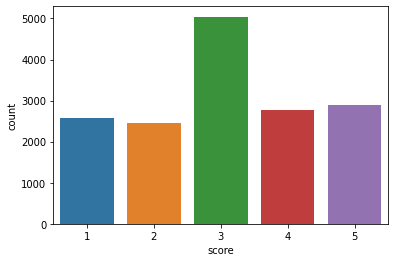

In [6]:
sns.countplot(df['score'])

In [7]:
def preprocess_score(score):
    if score < 3:
        score = 0
    elif score == 3:
        score = 1
    else:
        score = 2
    return score

[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

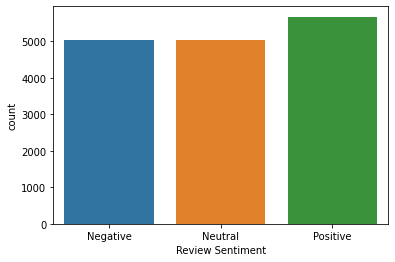

In [8]:
class_names = ['Negative', 'Neutral', 'Positive']
df.score = df.score.apply(preprocess_score)
ax = sns.countplot(df.score)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)

In [9]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, i):
        review = str(self.reviews[i])
        target = self.targets[i]

        encoding = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [10]:
def create_data_loader(
    df,
    tokenizer,
    max_len,
    batch_size
):
    ds = ReviewsDataset(
        reviews=df['content'].to_numpy(),
        targets=df['score'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        dataset=ds,
        batch_size=batch_size,
        num_workers=4
    )

In [11]:
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df.score
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42,
    stratify=df_test.score
)
df_train.shape, df_test.shape, df_val.shape

((12596, 11), (1575, 11), (1575, 11))

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
train_data_loader = create_data_loader(
    df_train, tokenizer, MAX_LEN, BATCH_SIZE
)
test_data_loader = create_data_loader(
    df_test, tokenizer, MAX_LEN, BATCH_SIZE
)
val_data_loader = create_data_loader(
    df_val, tokenizer, MAX_LEN, BATCH_SIZE
)

## Building a Sentiment Classifier

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.fcl = nn.Linear(self.bert_model.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        output = self.fcl(output)
        return output

In [15]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

## Loss, Optimizer and Scheduler

In [16]:
loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [17]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['target'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [20]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        train_acc = correct_predictions.double() / n_examples
        train_loss = np.mean(losses)

        return train_acc, train_loss

In [21]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*10)

    train_acc, train_loss = train(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        data_loader=train_data_loader,
        n_examples=len(df_train)
    )

    print(f'Train Loss {train_loss} Accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model=model,
        loss_fn=loss_fn,
        device=device,
        data_loader=val_data_loader,
        n_examples=len(df_val)
    )

    print(f'Validation Loss {val_loss} Accuracy {val_acc}')    
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/50
----------
Train Loss 0.44004955823972897 Accuracy 0.8273261352810416
Validation Loss 0.5696879860126611 Accuracy 0.7980952380952381

Epoch 2/50
----------
Train Loss 0.25764840060453814 Accuracy 0.9158463004128296
Validation Loss 0.7433040531897785 Accuracy 0.8133333333333334

Epoch 3/50
----------
Train Loss 0.18826219927594018 Accuracy 0.9441886313115275
Validation Loss 0.8462312845607297 Accuracy 0.8203174603174603

Epoch 4/50
----------
Train Loss 0.13587140891165295 Accuracy 0.9615751032073675
Validation Loss 0.9860748204624873 Accuracy 0.8368253968253968

Epoch 5/50
----------
Train Loss 0.10820257693126108 Accuracy 0.9698316926008257
Validation Loss 0.9886129819217722 Accuracy 0.8419047619047619

Epoch 6/50
----------
Train Loss 0.0946686433501223 Accuracy 0.9749126706891077
Validation Loss 1.075165366980887 Accuracy 0.8419047619047619

Epoch 7/50
----------
Train Loss 0.08142884613916607 Accuracy 0.9754684026675136
Validation Loss 1.0494365615577959 Accuracy 0.85142

In [22]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.8685714285714285

(0.0, 1.0)

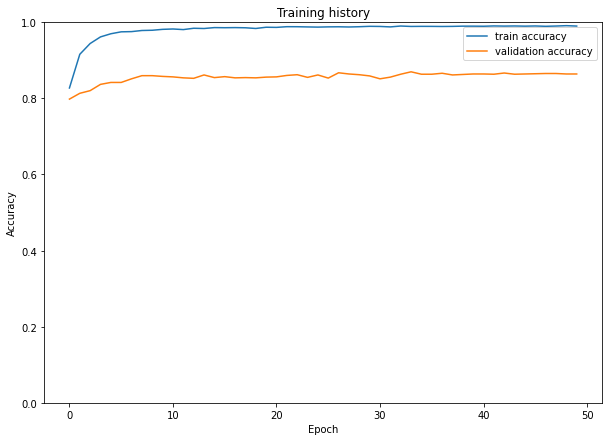

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [27]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    reviews = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            review = d['review']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            reviews.extend(review)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return reviews, predictions, predictions_probs, real_values

In [28]:
y_reviews, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

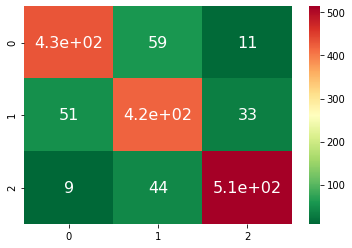

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})